In [1]:
import pandas as pd

# CSV 파일 읽기
df_energy = pd.read_csv('한국서부발전_시간별_발전량_utf-8_20230630.csv')
df_energy = df_energy.rename(columns={
    '발전기명': '발전구분',
    '년월일': '일자',
    '해당 시간 발전량(kWh)': '발전량(Wh)'
})

# 일자 형식이 datetime이어야 함
df_energy['일자'] = pd.to_datetime(df_energy['일자'])

# 변환 대상 기간 마스크
mask = (df_energy['일자'] >= '2021-09-01') & (df_energy['일자'] <= '2022-07-31')

# 해당 기간에만 발전량 * 1000
df_energy.loc[mask, '발전량(Wh)'] = df_energy.loc[mask, '발전량(Wh)'] * 1000

# 1. 발전량(Wh) → 발전량(kWh)로 환산
df_energy['발전량(kWh)'] = df_energy['발전량(Wh)'] / 1000

# 2. 기존 Wh 컬럼 제거 (선택)
df_energy = df_energy.drop(columns=['발전량(Wh)'])

df_energy['시간'] = df_energy['시간'].str.replace('시', '', regex=False).astype(int)
df_energy.head()



,발전구분,일자,설비용량(MW),시간,발전량(kWh)
0,세종시폐기물매립장태양광,2017-01-01,1.628,1,0.0
1,안산연성정수장태양광,2017-01-01,1.490,1,0.0
2,영암에프원태양광b,2017-01-01,13.296,1,0.0
3,세종시폐기물매립장태양광,2017-01-02,1.628,1,0.0
4,안산연성정수장태양광,2017-01-02,1.490,1,0.0


In [2]:
# 준공연도 열 생성 (기본값: None)
df_energy["준공연도"] = None

# 발전소별 준공연도 할당
df_energy.loc[df_energy["발전구분"] == "세종시폐기물매립장태양광", "준공연도"] = "'12.6"
df_energy.loc[df_energy["발전구분"] == "안산연성정수장태양광", "준공연도"] = "'12.8"
df_energy.loc[df_energy["발전구분"] == "영암에프원태양광b", "준공연도"] = "'12.12"

In [3]:
import pandas as pd

# 일자와 준공연도 날짜 형식으로 변환
df_energy['일자'] = pd.to_datetime(df_energy['일자'])

# 준공연도 문자열에서 연도와 월 추출 ('12.12 → 2012, 12)
df_energy['준공연도_연'] = df_energy['준공연도'].str.extract(r"'(\d+)\.")[0].astype(int) + 2000
df_energy['준공연도_월'] = df_energy['준공연도'].str.extract(r"\.(\d+)")[0].astype(int)

# 준공일 full datetime 생성
df_energy['준공일'] = pd.to_datetime(dict(year=df_energy['준공연도_연'], month=df_energy['준공연도_월'], day=1))

# 연식 계산: 날짜 차이 / 365.25일로 환산 → 소수점 연도 단위
df_energy['연식(년)'] = (df_energy['일자'] - df_energy['준공일']).dt.days / 365.25

# 👉 소수점 첫째 자리까지 반올림
df_energy['연식(년)'] = df_energy['연식(년)'].round(1)

# 중간 컬럼 정리 (선택)
df_energy = df_energy.drop(columns=['준공연도_연', '준공연도_월', '준공일'])

df_energy = df_energy.drop(columns=['준공연도'])
# 확인
df_energy.head()
df_energy.to_csv('df_energy_solar2.csv', index=False, encoding='utf-8-sig')



### EDA

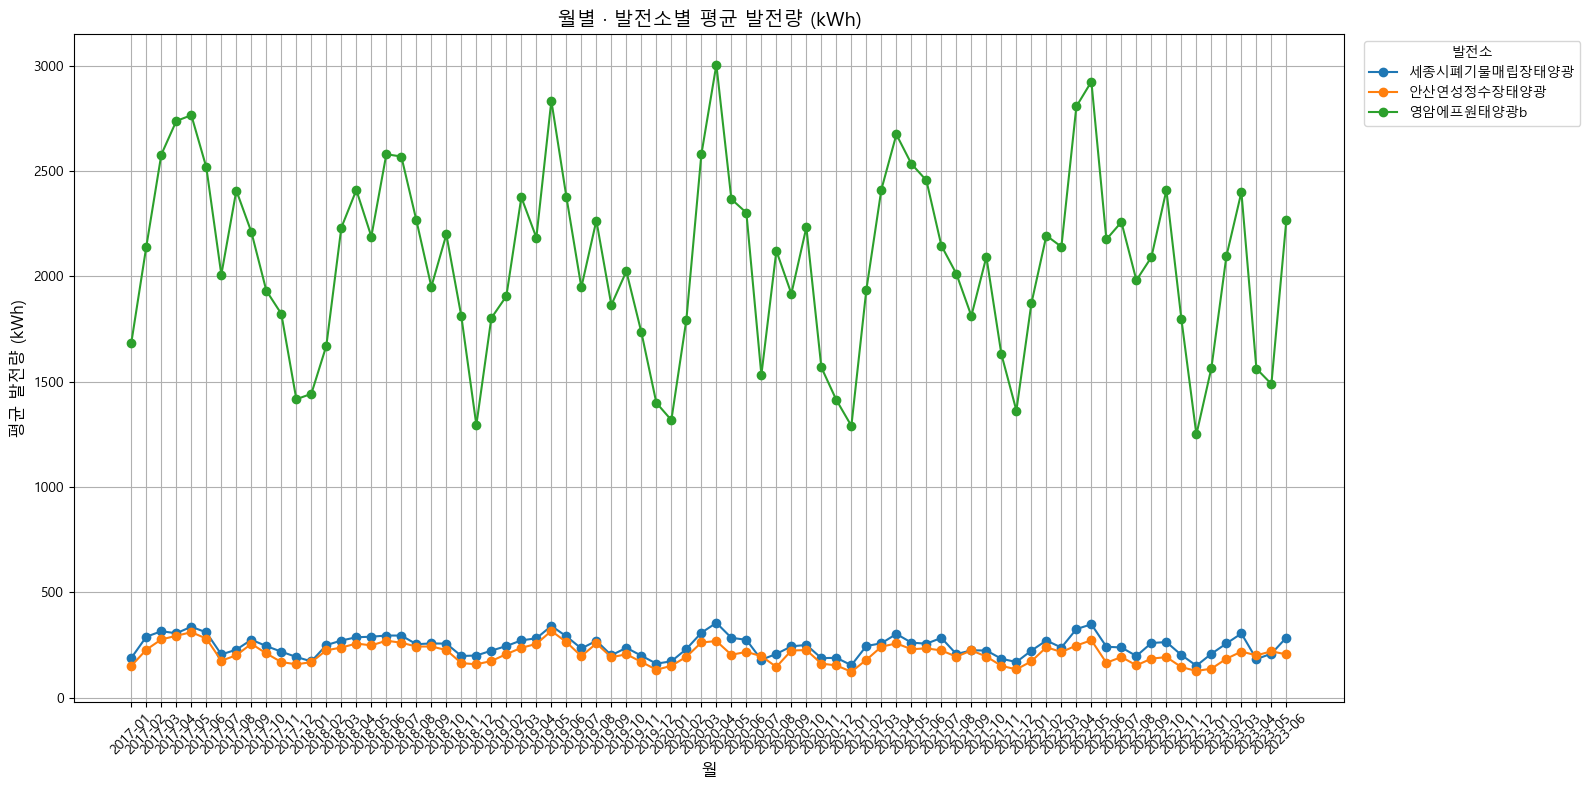

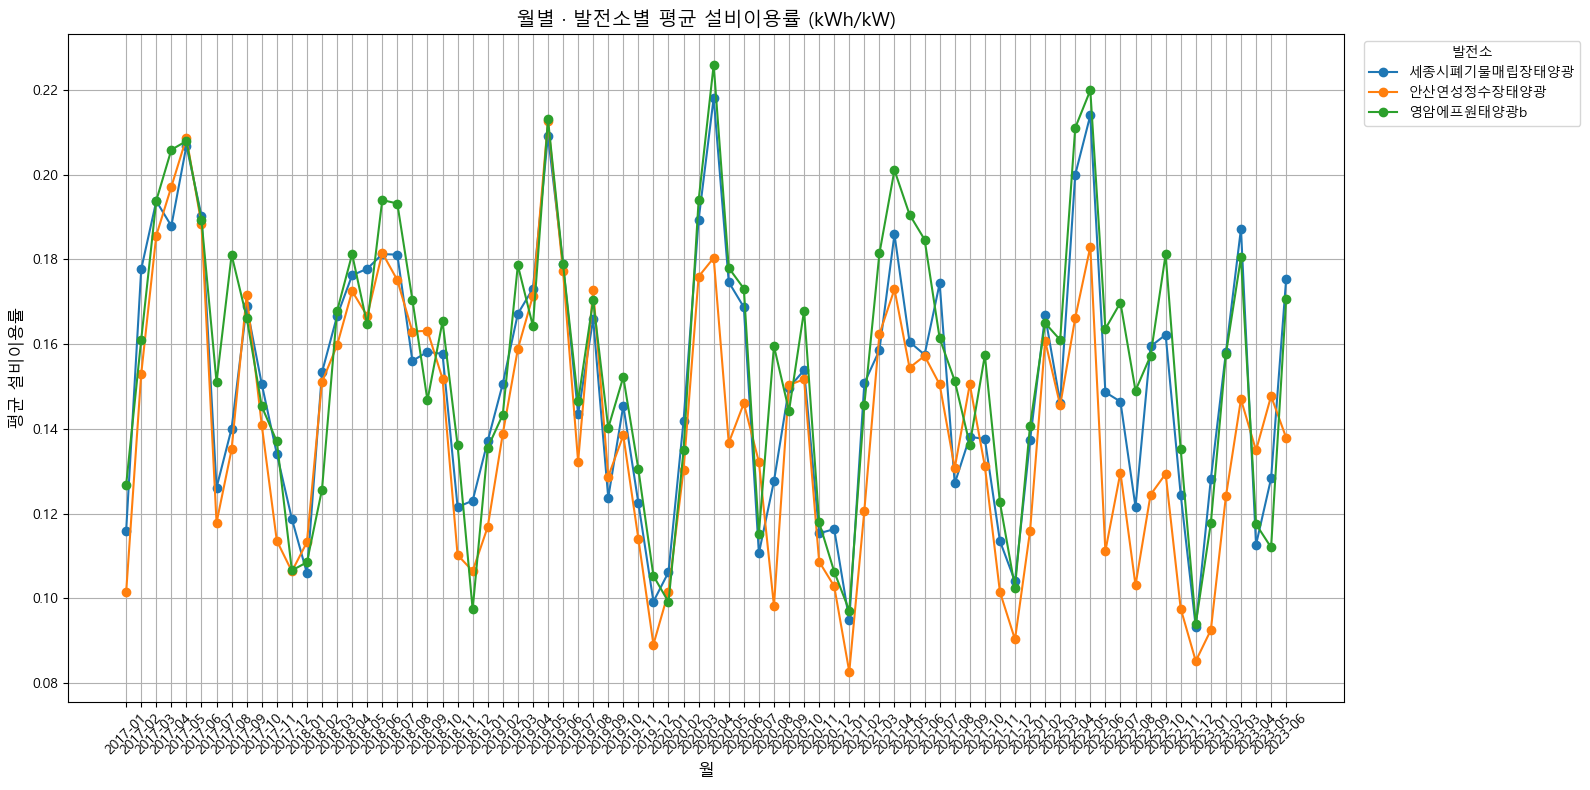

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import platform

# ✅ 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False

# ✅ 1. CSV 파일 불러오기
file_path = '한국서부발전_시간별_발전량_utf-8_20230630.csv'
df = pd.read_csv(file_path, encoding='utf-8-sig')

df = df.rename(columns={
    '발전기명': '발전구분',
    '년월일': '일자',
    '해당 시간 발전량(kWh)': '발전량(Wh)'
})

# 일자 형식이 datetime이어야 함
df['일자'] = pd.to_datetime(df['일자'])

# 변환 대상 기간 마스크
mask = (df['일자'] >= '2021-09-01') & (df['일자'] <= '2022-07-31')

# 해당 기간에만 발전량 * 1000
df.loc[mask, '발전량(Wh)'] = df.loc[mask, '발전량(Wh)'] * 1000

# 1. 발전량(Wh) → 발전량(kWh)로 환산
df['발전량(kWh)'] = df['발전량(Wh)'] / 1000

# 2. 기존 Wh 컬럼 제거 (선택)
df = df.drop(columns=['발전량(Wh)'])

df['시간'] = df['시간'].str.replace('시', '', regex=False).astype(int)

# ✅ 2. 날짜 변환 및 월 컬럼 생성
df['일자'] = pd.to_datetime(df['일자'])
df['월'] = df['일자'].dt.to_period('M')

# ✅ 3. 발전소 컬럼 생성
df['발전소'] = df['발전구분']

# ✅ 4. 발전량 기반 월별 평균
monthly_avg = df.groupby(['월', '발전소'])['발전량(kWh)'].mean().reset_index()

# ✅ 5. 설비이용률 계산 (kWh / (MW * 1000))
df['설비이용률'] = df['발전량(kWh)'] / (df['설비용량(MW)']*1000)
monthly_util = df.groupby(['월', '발전소'])['설비이용률'].mean().reset_index()

# ✅ 6. 그래프 1: 월별 · 발전소별 평균 발전량
plt.figure(figsize=(16, 8))
for name, group in monthly_avg.groupby('발전소'):
    plt.plot(group['월'].astype(str), group['발전량(kWh)'], marker='o', label=name)

plt.title('월별 · 발전소별 평균 발전량 (kWh)', fontsize=14)
plt.xlabel('월', fontsize=12)
plt.ylabel('평균 발전량 (kWh)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='발전소', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ✅ 7. 그래프 2: 월별 · 발전소별 평균 설비이용률
plt.figure(figsize=(16, 8))
for name, group in monthly_util.groupby('발전소'):
    plt.plot(group['월'].astype(str), group['설비이용률'], marker='o', label=name)

plt.title('월별 · 발전소별 평균 설비이용률 (kWh/kW)', fontsize=14)
plt.xlabel('월', fontsize=12)
plt.ylabel('평균 설비이용률', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='발전소', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [5]:
# ✅ 두 그래프를 하나의 이미지로 저장
fig, axes = plt.subplots(2, 1, figsize=(16, 14))  # 두 행, 한 열

# ▶️ 그래프 1: 월별 평균 발전량
for name, group in monthly_avg.groupby('발전소'):
    axes[0].plot(group['월'].astype(str), group['발전량(kWh)'], marker='o', label=name)

axes[0].set_title('월별 · 발전소별 평균 발전량 (kWh)', fontsize=14)
axes[0].set_xlabel('월', fontsize=12)
axes[0].set_ylabel('평균 발전량 (kWh)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)
axes[0].legend(title='발전소', bbox_to_anchor=(1.01, 1), loc='upper left')

# ▶️ 그래프 2: 월별 평균 설비이용률
for name, group in monthly_util.groupby('발전소'):
    axes[1].plot(group['월'].astype(str), group['설비이용률'], marker='o', label=name)

axes[1].set_title('월별 · 발전소별 평균 설비이용률 (kWh/kW)', fontsize=14)
axes[1].set_xlabel('월', fontsize=12)
axes[1].set_ylabel('평균 설비이용률', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)
axes[1].legend(title='발전소', bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()

# ✅ 저장
plt.savefig('solar2_발전량+설비이용률.png', dpi=300)
plt.close()


### 기상청 API 데이터 불러오기

In [7]:
import requests
import ssl
from requests.adapters import HTTPAdapter
from urllib3.poolmanager import PoolManager

class SSLAdapter(HTTPAdapter):
    def __init__(self, ssl_context=None, **kwargs):
        self.ssl_context = ssl_context
        super().__init__(**kwargs)

    def init_poolmanager(self, *args, **kwargs):
        kwargs['ssl_context'] = self.ssl_context
        return super().init_poolmanager(*args, **kwargs)

# TLS 1.2 이상의 context 강제 설정
context = ssl.create_default_context()
context.set_ciphers('DEFAULT@SECLEVEL=1')  # 낮은 보안 레벨 허용할 경우

session = requests.Session()
session.mount('https://', SSLAdapter(context))

# 요청 보내기
url = "http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"
params = {
    "serviceKey": "zJLFmDMckurk+au32kOHTxsrU5gG2NAadNE68xYaBW8PBJtdXN7F4QEpuW6f68GL0qLcMQsmgyPHxbOs43NCBA==",
    "numOfRows": "1000",
    "pageNo": "1",
    "dataType": "JSON",
    "base_date": "20250627",
    "base_time": "0500",
    "nx": "55",
    "ny": "127"
}
response = session.get(url, params=params)
print(response.json())


{'response': {'header': {'resultCode': '00', 'resultMsg': 'NORMAL_SERVICE'}, 'body': {'dataType': 'JSON', 'items': {'item': [{'baseDate': '20250627', 'baseTime': '0500', 'category': 'TMP', 'fcstDate': '20250627', 'fcstTime': '0600', 'fcstValue': '20', 'nx': 55, 'ny': 127}, {'baseDate': '20250627', 'baseTime': '0500', 'category': 'UUU', 'fcstDate': '20250627', 'fcstTime': '0600', 'fcstValue': '0.1', 'nx': 55, 'ny': 127}, {'baseDate': '20250627', 'baseTime': '0500', 'category': 'VVV', 'fcstDate': '20250627', 'fcstTime': '0600', 'fcstValue': '0.4', 'nx': 55, 'ny': 127}, {'baseDate': '20250627', 'baseTime': '0500', 'category': 'VEC', 'fcstDate': '20250627', 'fcstTime': '0600', 'fcstValue': '194', 'nx': 55, 'ny': 127}, {'baseDate': '20250627', 'baseTime': '0500', 'category': 'WSD', 'fcstDate': '20250627', 'fcstTime': '0600', 'fcstValue': '0.4', 'nx': 55, 'ny': 127}, {'baseDate': '20250627', 'baseTime': '0500', 'category': 'SKY', 'fcstDate': '20250627', 'fcstTime': '0600', 'fcstValue': '4', 

In [8]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# ----------------------------------------------------------------------
# 1. API 호출을 위한 기본 설정
# ----------------------------------------------------------------------

now = datetime.now()
if now.hour < 5:
    base_date = (now - timedelta(days=1)).strftime('%Y%m%d')
else:
    base_date = now.strftime('%Y%m%d')

url = "http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst"
serviceKey = "zJLFmDMckurk+au32kOHTxsrU5gG2NAadNE68xYaBW8PBJtdXN7F4QEpuW6f68GL0qLcMQsmgyPHxbOs43NCBA=="  # 본인의 서비스 키로 변경하세요

# ----------------------------------------------------------------------
# 2. 반복문을 사용해 모든 페이지의 데이터 수집
# ----------------------------------------------------------------------

all_items = []
page_no = 1
num_of_rows = 5000

print("데이터 수집을 시작합니다...")

while True:
    print(f" - {page_no} 페이지 데이터 요청 중...")
    
    params = {
        'serviceKey': serviceKey,
        'numOfRows': str(num_of_rows),
        'pageNo': str(page_no),
        'dataType': 'JSON',
        'base_date': base_date,
        'base_time': '0500',
        'nx': '55',
        'ny': '127'
    }

    try:
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()

        data = response.json()
        
        if data['response']['header']['resultCode'] != '00':
            print(f"❌ API 에러 응답: {data['response']['header']['resultMsg']}")
            break

        items = data['response']['body']['items'].get('item', [])
        all_items.extend(items)

        if len(items) < num_of_rows:
            print(f"마지막 페이지({page_no})입니다. 데이터 수집을 완료합니다.")
            break

        page_no += 1

    except requests.exceptions.RequestException as e:
        print(f"❌ 네트워크 또는 HTTP 에러 발생: {e}")
        break
    except requests.exceptions.JSONDecodeError:
        print("❌ JSON 파싱 에러: 서버 응답이 유효한 JSON이 아닙니다.")
        print(f"--- 서버 실제 응답 (Status: {response.status_code}) ---")
        print(response.text)
        break
    except KeyError:
        print("❌ 데이터 구조 에러: 응답 받은 JSON의 키가 예상과 다릅니다.")
        print("--- 서버 실제 응답 ---")
        print(data)
        break

# ----------------------------------------------------------------------
# 3. 수집된 모든 데이터를 표(DataFrame)로 변환 및 출력
# ----------------------------------------------------------------------

if all_items:
    df = pd.DataFrame(all_items)
    df.drop_duplicates(inplace=True)
    
    print(f"\n총 {len(df)}개의 유니크한 데이터를 수집했습니다. 표로 변환합니다.")

    # fcstDate와 fcstTime을 인덱스로 지정하여 pivot_table 생성
    pivot_df = df.pivot_table(
        index=['fcstDate', 'fcstTime'], 
        columns='category', 
        values='fcstValue', 
        aggfunc='first'
    ).reset_index()

    desired_order = ['fcstDate', 'fcstTime', 'TMP', 'SKY', 'PTY', 'POP', 'PCP', 'REH', 'WSD', 'SNO']
    current_columns = [col for col in desired_order if col in pivot_df.columns]
    remaining_columns = [col for col in pivot_df.columns if col not in current_columns]
    pivot_df = pivot_df[current_columns + remaining_columns]

    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)

    print("\n--- 기상청 단기예보 (전체 데이터, 날짜 포함) ---")
    print(pivot_df)
else:
    print("\n수집된 데이터가 없습니다. 서비스 키 또는 요청 파라미터를 확인해주세요.")


데이터 수집을 시작합니다...
 - 1 페이지 데이터 요청 중...
마지막 페이지(1)입니다. 데이터 수집을 완료합니다.

총 907개의 유니크한 데이터를 수집했습니다. 표로 변환합니다.

--- 기상청 단기예보 (전체 데이터, 날짜 포함) ---
category  fcstDate fcstTime TMP SKY PTY POP   PCP  REH  WSD   SNO   TMN   TMX  UUU  VEC  VVV   WAV
0         20250629     0600  23   4   0  30  강수없음  100  2.8  적설없음   NaN   NaN    0  178  2.8  -999
1         20250629     0700  23   4   0  30  강수없음   95  3.2  적설없음   NaN   NaN  0.3  185  3.2  -999
2         20250629     0800  24   4   0  30  강수없음   95  3.4  적설없음   NaN   NaN  0.5  188  3.4  -999
3         20250629     0900  24   4   0  30  강수없음   95  3.3  적설없음   NaN   NaN  0.8  194  3.2  -999
4         20250629     1000  25   4   0  30  강수없음   90  3.1  적설없음   NaN   NaN  0.9  197    3  -999
5         20250629     1100  25   4   0  30  강수없음   90  3.4  적설없음   NaN   NaN  1.1  199  3.2  -999
6         20250629     1200  26   4   0  30  강수없음   90  3.5  적설없음   NaN   NaN  1.3  202  3.2  -999
7         20250629     1300  26   4   0  30  강수없음   90  3.7  적설없음   N

In [9]:
pivot_df

category,fcstDate,fcstTime,TMP,SKY,PTY,POP,PCP,REH,WSD,SNO,TMN,TMX,UUU,VEC,VVV,WAV
0,20250629,0600,23,4,0,30,강수없음,100,2.8,적설없음,NaN,NaN,0,178,2.8,-999
1,20250629,0700,23,4,0,30,강수없음,95,3.2,적설없음,NaN,NaN,0.3,185,3.2,-999
2,20250629,0800,24,4,0,30,강수없음,95,3.4,적설없음,NaN,NaN,0.5,188,3.4,-999
3,20250629,0900,24,4,0,30,강수없음,95,3.3,적설없음,NaN,NaN,0.8,194,3.2,-999
4,20250629,1000,25,4,0,30,강수없음,90,3.1,적설없음,NaN,NaN,0.9,197,3,-999
5,20250629,1100,25,4,0,30,강수없음,90,3.4,적설없음,NaN,NaN,1.1,199,3.2,-999
6,20250629,1200,26,4,0,30,강수없음,90,3.5,적설없음,NaN,NaN,1.3,202,3.2,-999
7,20250629,1300,26,4,0,30,강수없음,90,3.7,적설없음,NaN,NaN,1.5,204,3.4,-999
8,20250629,1400,27,4,0,30,강수없음,80,3.8,적설없음,NaN,NaN,1.5,203,3.5,-999
9,20250629,1500,27,4,0,30,강수없음,80,3.2,적설없음,NaN,28.0,1.3,204,2.9,-999


<span style="font-size:12px">

## 🌦 기상청 예보 데이터 컬럼 설명

| 컬럼명 | 의미 | 단위 또는 값 |
|--------|------|---------------|
| `fcstDate` | 예보 날짜 | 예: `20250627` → 2025년 6월 27일 |
| `fcstTime` | 예보 시각 | 예: `0600` → 오전 6시 |
| `TMP` | 기온 | ℃ (섭씨 온도) |
| `SKY` | 하늘 상태 | 1: 맑음, 3: 구름 많음, 4: 흐림 |
| `PTY` | 강수 형태 | 0: 없음, 1: 비, 2: 비/눈, 3: 눈, 4: 소나기 등 |
| `POP` | 강수 확률 | % |
| `PCP` | 1시간 강수량 | mm 또는 `"강수없음"` |
| `REH` | 습도 | % |
| `WSD` | 풍속 | m/s (미터/초) |
| `SNO` | 1시간 적설량 | cm 또는 `"적설없음"` |
| `TMN` | 일 최저기온 | ℃ (해당 날짜 전체의 최저 예상 기온) |
| `TMX` | 일 최고기온 | ℃ (해당 날짜 전체의 최고 예상 기온) |
| `UUU` | 동서 바람 성분 | m/s (음수: 서풍, 양수: 동풍) |
| `VVV` | 남북 바람 성분 | m/s (음수: 북풍, 양수: 남풍) |
| `VEC` | 풍향 | 도 (°), 0: 북, 90: 동, 180: 남, 270: 서 |
| `WAV` | 파고 (해상용) | m (육상 예보에서는 -999로 무효 값 처리됨) |

---

## 💡 추가 설명

- `UUU`, `VVV`는 바람의 벡터 성분입니다.  
  → 풍속(`WSD`)과 풍향(`VEC`)으로부터 계산 가능  
  → `풍속^2 = UUU^2 + VVV^2`, `풍향 = atan2(UUU, VVV)`

- `TMX`, `TMN`은 하루에 한 번만 나타나며, 그 날 전체를 대표하는 예보입니다.

- `PCP`, `SNO`는 `"강수없음"`, `"적설없음"`처럼 문자열이 포함되어 있어 수치 분석 시 처리 필요합니다.

- `WAV`는 해양 예보 전용 항목이며, 육상에서는 대부분 `-999`로 나타나며 무시해도 무방합니다.


### 기상청 API 데이터 전처리

In [10]:
pivot_df.head(5)

category,fcstDate,fcstTime,TMP,SKY,PTY,POP,PCP,REH,WSD,SNO,TMN,TMX,UUU,VEC,VVV,WAV
0,20250629,0600,23,4,0,30,강수없음,100,2.8,적설없음,NaN,NaN,0,178,2.8,-999
1,20250629,0700,23,4,0,30,강수없음,95,3.2,적설없음,NaN,NaN,0.3,185,3.2,-999
2,20250629,0800,24,4,0,30,강수없음,95,3.4,적설없음,NaN,NaN,0.5,188,3.4,-999
3,20250629,0900,24,4,0,30,강수없음,95,3.3,적설없음,NaN,NaN,0.8,194,3.2,-999
4,20250629,1000,25,4,0,30,강수없음,90,3.1,적설없음,NaN,NaN,0.9,197,3,-999


In [11]:
# 제거할 컬럼 리스트
drop_columns = ['TMN', 'TMX', 'WAV', 'UUU', 'VVV', 'PTY', 'POP']

# 컬럼이 존재할 경우에만 삭제하도록 처리
pivot_df = pivot_df.drop(columns=[col for col in drop_columns if col in pivot_df.columns])


In [12]:
# 컬럼명 매핑 딕셔너리 (SKY 추가됨)
rename_dict = {
    'fcstDate': '일자',
    'fcstTime': '시간',
    'TMP': '기온(°C)',
    'PCP': '강수량(mm)',
    'REH': '습도(%)',
    'WSD': '풍속(m/s)',
    'SNO': '적설(cm)',
    'VEC': '풍향(16방위)',
    'SKY': '하늘상태',
}

# 컬럼명 변경
pivot_df = pivot_df.rename(columns=rename_dict)



In [13]:
# 일자: 문자열 '20250627' → '2025-06-27'로 변환
pivot_df['일자'] = pd.to_datetime(pivot_df['일자'], format='%Y%m%d').dt.strftime('%Y-%m-%d')

# 시간: 문자열 '0600' → 정수 6
pivot_df['시간'] = pivot_df['시간'].astype(str).str[:2].astype(int)


In [14]:
import re

def clean_precip(val):
    # NaN이면 그대로 반환
    if pd.isna(val):
        return val
    val = str(val)
    
    # 강수없음, 적설없음 → 0
    if '없음' in val:
        return 0.0
    
    # 1mm 미만 → 관례적으로 0.5로 처리하거나 0.0으로 처리 가능
    if '미만' in val:
        return 0.5  # 또는 0.0으로 바꿔도 됨
    
    # 숫자만 추출 (예: '2.5mm' → 2.5)
    numeric_part = re.findall(r"[\d.]+", val)
    return float(numeric_part[0]) if numeric_part else 0.0

# 적용
pivot_df['강수량(mm)'] = pivot_df['강수량(mm)'].apply(clean_precip)
pivot_df['적설(cm)'] = pivot_df['적설(cm)'].apply(clean_precip)


In [41]:
pivot_df.head(5)

category,일자,시간,기온(°C),하늘상태,강수량(mm),습도(%),풍속(m/s),적설(cm),풍향(16방위)
0,2025-06-27,6,20,4,0.0,95,0.4,0.0,194
1,2025-06-27,7,20,4,0.0,90,0.8,0.0,270
2,2025-06-27,8,21,4,0.0,90,0.8,0.0,23
3,2025-06-27,9,22,4,0.0,85,1.5,0.0,16
4,2025-06-27,10,23,4,0.0,85,2.4,0.0,57


### 기상청 csv 데이터 전처리

In [6]:
df_weather = pd.read_csv('weather_merged_solar_2017-2023.csv')
df_weather.head(5)

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일사(MJ/m2),적설(cm),전운량(10분위)
0,165,목포,2017-01-01 00:00,5.7,NaN,0.4,0.0,89.0,1025.5,NaN,NaN,6.0
1,165,목포,2017-01-01 01:00,5.0,NaN,1.8,160.0,93.0,1025.4,NaN,NaN,NaN
2,165,목포,2017-01-01 02:00,4.1,NaN,0.8,140.0,93.0,1025.4,NaN,NaN,NaN
3,165,목포,2017-01-01 03:00,3.3,NaN,1.5,160.0,94.0,1025.1,NaN,NaN,0.0
4,165,목포,2017-01-01 04:00,2.5,NaN,1.8,160.0,95.0,1024.9,NaN,NaN,0.0


In [7]:
# 제거할 컬럼 리스트
drop_columns = ['지점', '현지기압(hPa)'] #'일사(MJ/m2)'
# 컬럼이 존재할 경우에만 삭제하도록 처리
df_weather = df_weather.drop(columns=[col for col in drop_columns if col in df_weather.columns])
df_weather.head(5)

,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),일사(MJ/m2),적설(cm),전운량(10분위)
0,목포,2017-01-01 00:00,5.7,NaN,0.4,0.0,89.0,NaN,NaN,6.0
1,목포,2017-01-01 01:00,5.0,NaN,1.8,160.0,93.0,NaN,NaN,NaN
2,목포,2017-01-01 02:00,4.1,NaN,0.8,140.0,93.0,NaN,NaN,NaN
3,목포,2017-01-01 03:00,3.3,NaN,1.5,160.0,94.0,NaN,NaN,0.0
4,목포,2017-01-01 04:00,2.5,NaN,1.8,160.0,95.0,NaN,NaN,0.0


In [8]:
# datetime 형식으로 변환
df_weather['일시'] = pd.to_datetime(df_weather['일시'])

# 일자, 시간 컬럼 생성
df_weather['일자'] = df_weather['일시'].dt.strftime('%Y-%m-%d')
df_weather['시간'] = df_weather['일시'].dt.hour

# 조건: 시간이 0이면
mask = df_weather['시간'] == 0

# 시간 0을 24로 바꾸고, 일자는 하루 전으로 변경
df_weather.loc[mask, '시간'] = 24
df_weather.loc[mask, '일자'] = (df_weather.loc[mask, '일시'] - pd.Timedelta(days=1)).dt.strftime('%Y-%m-%d')

# 기존 '일시' 컬럼 삭제
df_weather = df_weather.drop(columns=['일시'])

# 확인
df_weather.head(5)

,지점명,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),일사(MJ/m2),적설(cm),전운량(10분위),일자,시간
0,목포,5.7,NaN,0.4,0.0,89.0,NaN,NaN,6.0,2016-12-31,24
1,목포,5.0,NaN,1.8,160.0,93.0,NaN,NaN,NaN,2017-01-01,1
2,목포,4.1,NaN,0.8,140.0,93.0,NaN,NaN,NaN,2017-01-01,2
3,목포,3.3,NaN,1.5,160.0,94.0,NaN,NaN,0.0,2017-01-01,3
4,목포,2.5,NaN,1.8,160.0,95.0,NaN,NaN,0.0,2017-01-01,4


In [9]:
# 현재 컬럼들 확인
cols = df_weather.columns.tolist()

# 기준이 되는 컬럼 이름 (예: '지점' 또는 '지점명')
key_col = '지점명'  # 또는 '지점'으로 바꿔도 됨

# '지점명' 다음에 '일자', '시간'을 삽입
if key_col in cols:
    idx = cols.index(key_col)
    # 기존에 '일자', '시간'이 이미 들어있다면 먼저 제거
    for c in ['일자', '시간']:
        if c in cols:
            cols.remove(c)
    # 삽입
    new_order = cols[:idx+1] + ['일자', '시간'] + cols[idx+1:]
    df_weather = df_weather[new_order]
else:
    print(f"⚠️ 컬럼 '{key_col}'이 존재하지 않습니다.")

df_weather.head(5)

,지점명,일자,시간,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),일사(MJ/m2),적설(cm),전운량(10분위)
0,목포,2016-12-31,24,5.7,NaN,0.4,0.0,89.0,NaN,NaN,6.0
1,목포,2017-01-01,1,5.0,NaN,1.8,160.0,93.0,NaN,NaN,NaN
2,목포,2017-01-01,2,4.1,NaN,0.8,140.0,93.0,NaN,NaN,NaN
3,목포,2017-01-01,3,3.3,NaN,1.5,160.0,94.0,NaN,NaN,0.0
4,목포,2017-01-01,4,2.5,NaN,1.8,160.0,95.0,NaN,NaN,0.0


In [10]:
def map_cloud_to_sky(cloud):
    if pd.isna(cloud):
        return None
    try:
        c = float(cloud)
    except:
        return None
    if c <= 2:
        return 1
    elif c <= 7:
        return 3
    else:
        return 4
    
df_weather = df_weather.rename(columns={'전운량(10분위)': '하늘상태'})

# 전운량 컬럼이 '전운량(10분위)'라는 이름일 경우
df_weather['하늘상태'] = df_weather['하늘상태'].apply(map_cloud_to_sky)


df_weather.head(5)

,지점명,일자,시간,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),일사(MJ/m2),적설(cm),하늘상태
0,목포,2016-12-31,24,5.7,NaN,0.4,0.0,89.0,NaN,NaN,3.0
1,목포,2017-01-01,1,5.0,NaN,1.8,160.0,93.0,NaN,NaN,NaN
2,목포,2017-01-01,2,4.1,NaN,0.8,140.0,93.0,NaN,NaN,NaN
3,목포,2017-01-01,3,3.3,NaN,1.5,160.0,94.0,NaN,NaN,1.0
4,목포,2017-01-01,4,2.5,NaN,1.8,160.0,95.0,NaN,NaN,1.0


In [11]:
df_weather['강수량(mm)'] = df_weather['강수량(mm)'].fillna(0)
df_weather['적설(cm)'] = df_weather['적설(cm)'].fillna(0)
df_weather['일사(MJ/m2)'] = df_weather['일사(MJ/m2)'].fillna(0)


### 발전량 데이터 + 기상청 데이터

In [12]:
# 3. 발전소 → 지점명 매핑
plant_to_location = {
    '세종시폐기물매립장태양광': '청주',
    '안산연성정수장태양광': '수원',
    '영암에프원태양광b': '목포',
}


# 4. 지점명 컬럼 추가
df_energy['지점명'] = df_energy['발전구분'].map(plant_to_location)

df_energy['지점명'] = df_energy['지점명'].astype(str).str.strip()
df_weather['지점명'] = df_weather['지점명'].astype(str).str.strip()

# 5. 날짜 형식 맞추기 (둘 다 'YYYY-MM-DD' 형태여야 병합됨)
df_energy['일자'] = pd.to_datetime(df_energy['일자']).dt.strftime('%Y-%m-%d')
df_weather['일자'] = pd.to_datetime(df_weather['일자']).dt.strftime('%Y-%m-%d')

df_energy['시간'] = df_energy['시간'].astype(int)
df_weather['시간'] = df_weather['시간'].astype(int)

# 6. 병합: 지점명 + 일자 + 시간 기준
df_merged = pd.merge(df_energy, df_weather, on=['지점명', '일자', '시간'], how='left')

# 7. 결과 확인 (앞부분 출력)
print(df_merged.head())

# 8. 결과 저장
df_merged.to_csv('df_merged_solar.csv', index=False, encoding='utf-8-sig')


           발전구분          일자  설비용량(MW)  시간  발전량(kWh)  연식(년) 지점명  기온(°C)  \
0  세종시폐기물매립장태양광  2017-01-01     1.628   1       0.0    4.6  청주     2.2   
1    안산연성정수장태양광  2017-01-01     1.490   1       0.0    4.4  수원     0.1   
2     영암에프원태양광b  2017-01-01    13.296   1       0.0    4.1  목포     5.0   
3  세종시폐기물매립장태양광  2017-01-02     1.628   1       0.0    4.6  청주     2.8   
4    안산연성정수장태양광  2017-01-02     1.490   1       0.0    4.4  수원     4.4   

   강수량(mm)  풍속(m/s)  풍향(16방위)  습도(%)  일사(MJ/m2)  적설(cm)  하늘상태  
0      0.0      0.2       0.0   78.0        0.0     0.0   NaN  
1      0.0      0.3       0.0   96.0        0.0     0.0   NaN  
2      0.0      1.8     160.0   93.0        0.0     0.0   NaN  
3      0.0      0.5     180.0   76.0        0.0     0.0   NaN  
4      0.0      0.6     200.0   82.0        0.0     0.0   NaN  


In [13]:
df_merged.tail()

,발전구분,일자,설비용량(MW),시간,발전량(kWh),연식(년),지점명,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),일사(MJ/m2),적설(cm),하늘상태
170629,안산연성정수장태양광,2023-06-29,1.490,24,0.0,10.9,수원,23.1,0.0,2.1,200.0,98.0,0.0,0.0,4.0
170630,영암에프원태양광b,2023-06-29,13.296,24,0.0,10.6,목포,23.6,5.8,4.2,180.0,98.0,0.0,0.0,4.0
170631,세종시폐기물매립장태양광,2023-06-30,1.628,24,0.0,11.1,청주,25.2,0.0,1.0,270.0,86.0,0.0,0.0,4.0
170632,안산연성정수장태양광,2023-06-30,1.490,24,0.0,10.9,수원,22.7,0.0,1.1,230.0,93.0,0.0,0.0,3.0
170633,영암에프원태양광b,2023-06-30,13.296,24,0.0,10.6,목포,22.8,0.0,0.5,250.0,99.0,0.0,0.0,4.0


### 통합 데이터셋 EDA

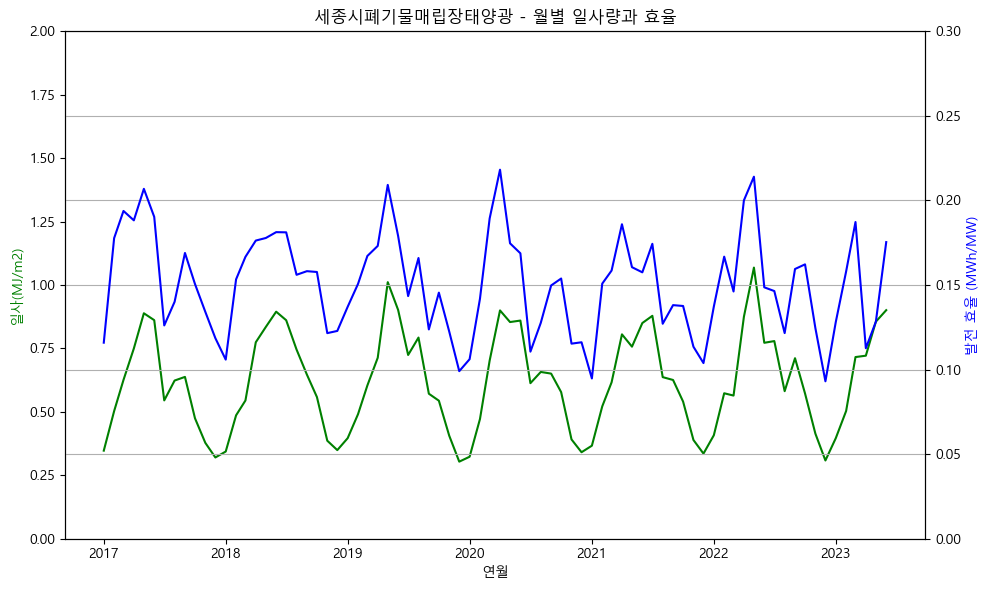

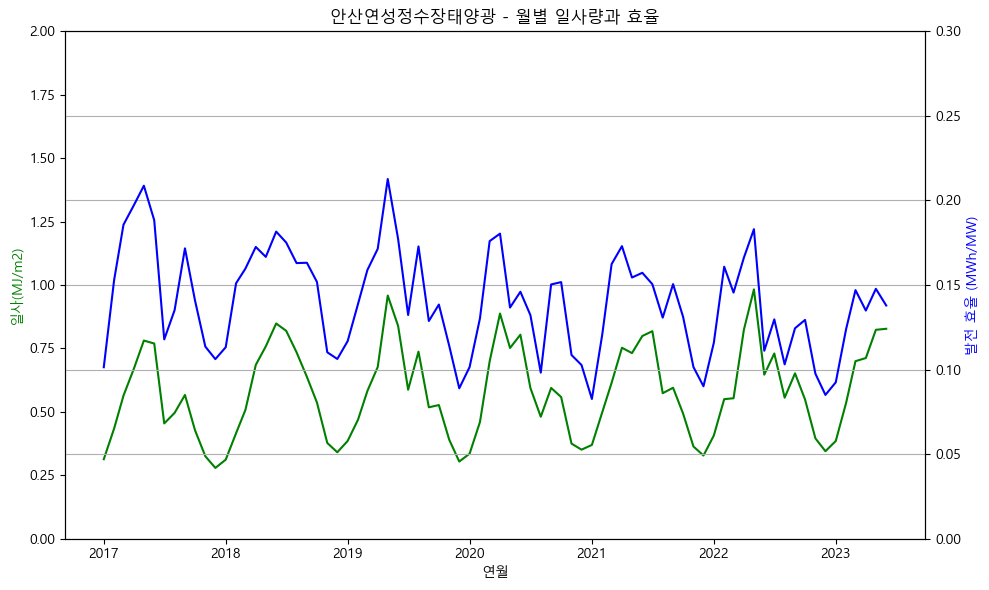

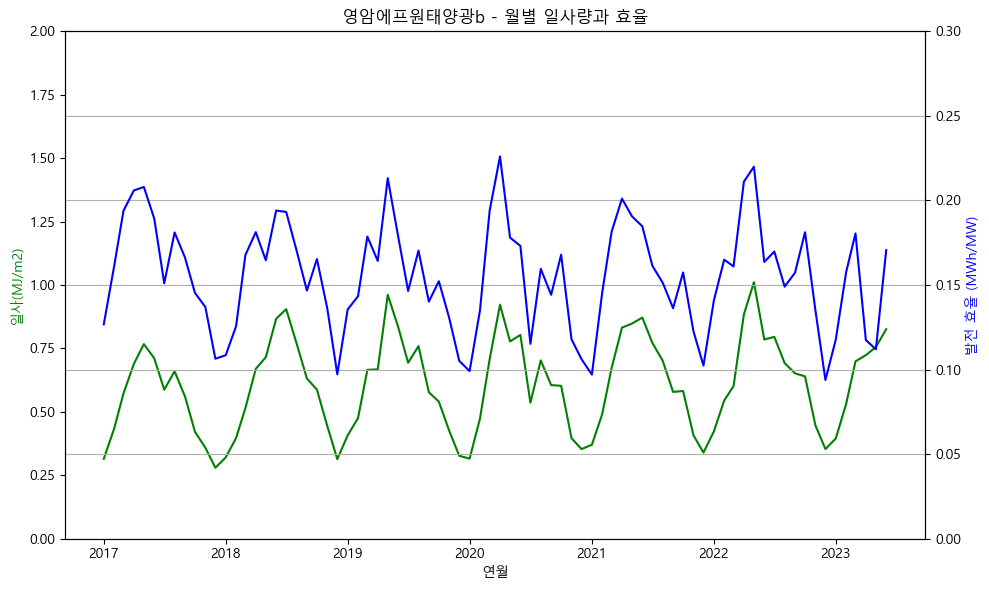

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 연월 처리
df_merged['일자'] = pd.to_datetime(df_merged['일자'], errors='coerce')
df_merged['연월'] = df_merged['일자'].dt.to_period('M').astype(str)
df_merged['효율'] = df_merged['발전량(kWh)'] / df_merged['설비용량(MW)'] / 1000  # ⚠️ 1000으로 나눔
df_merged = df_merged.dropna(subset=['효율', '일사(MJ/m2)', '연월', '발전구분'])

# 고정된 y축 범위 설정
풍속_min, 풍속_max = 0, 2
효율_min, 효율_max = 0, 0.3  # ⚠️ 효율 y축도 0~5로 조정

# 발전소 목록
plants = df_merged['발전구분'].unique()

# 3. 발전소별 그래프
for plant in plants:
    sub = df_merged[df_merged['발전구분'] == plant]
    if sub.empty:
        continue

    monthly = sub.groupby('연월')[['일사(MJ/m2)', '효율']].mean().reset_index()
    monthly['연월'] = pd.to_datetime(monthly['연월'])
    monthly = monthly.sort_values('연월')

    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax2 = ax1.twinx()

    ax1.plot(monthly['연월'], monthly['일사(MJ/m2)'], 'g-', label='일사(MJ/m2)')
    ax2.plot(monthly['연월'], monthly['효율'], 'b-', label='발전 효율 (MWh/MW)')

    ax1.set_xlabel('연월')
    ax1.set_ylabel('일사(MJ/m2)', color='g')
    ax2.set_ylabel('발전 효율 (MWh/MW)', color='b')  # 단위도 반영

    ax1.set_ylim(풍속_min, 풍속_max)
    ax2.set_ylim(효율_min, 효율_max)

    plt.title(f'{plant} - 월별 일사량과 효율')
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()


In [15]:
import math
import matplotlib.pyplot as plt

plants = df_merged['발전구분'].unique()
num_plants = len(plants)
cols = 2  # 열 수 (그래프를 2개씩 가로로 배치)
rows = math.ceil(num_plants / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, 6 * rows), sharex=False)
axes = axes.flatten()  # 2D → 1D로 평탄화

for i, plant in enumerate(plants):
    sub = df_merged[df_merged['발전구분'] == plant]
    if sub.empty:
        continue

    monthly = sub.groupby('연월')[['일사(MJ/m2)', '효율']].mean().reset_index()
    monthly['연월'] = pd.to_datetime(monthly['연월'])
    monthly = monthly.sort_values('연월')

    ax1 = axes[i]
    ax2 = ax1.twinx()

    ax1.plot(monthly['연월'], monthly['일사(MJ/m2)'], 'g-', label='일사량')
    ax2.plot(monthly['연월'], monthly['효율'], 'b-', label='효율')

    ax1.set_title(plant)
    ax1.set_ylim(0, 2)
    ax2.set_ylim(0, 0.3)

    ax1.set_ylabel('일사(MJ/m2)', color='g')
    ax2.set_ylabel('효율(MWh/MW)', color='b')
    ax1.tick_params(axis='x', rotation=45)

# 남는 서브플롯 지우기 (예: 5개 플롯인데 6칸 잡혔을 경우)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('solar2_일사량-발전효율 - 발전소별 월별 분석', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # 제목 공간 확보

# 🔹 한 번에 저장
plt.savefig('solar2_일사량-발전효율_ALL.png', dpi=300)
plt.close()
